<span style="font-family: cursive; font-size: 28px;">Data Science Class Project</span>  

<span style="font-family: cursive; font-size: 20px;">Project Title: Fully Connected Neural Network for Binding Affinity Prediction from Molecular Fingerprints. </span>  

<span style="font-family: cursive; font-size: 20px;">Name: Daniel Eduardo Garzon Otero</span>

<span style="font-family: cursive; font-size: 16px;">The need for accurate prediction of binding affinity, which is important in drug discovery and design. By using molecular fingerprints and a fully connected neural network, I hope to improve the accuracy of binding affinity prediction compared to existing methods. Results of this project could contribute to the development of more effective drugs and therapies.</span>  

<span style="font-family: cursive; font-size: 16px;"> I will use the PDB_Bind database: http://www.pdbbind.org.cn/ , which contains information about protein-ligand interactions obtained from the Protein Data Bank (PDB). Specifically, PDBBind. This Data set was provided from Dr. Camille Bilodeau.</span>

<span style="font-family: cursive; font-size: 16px;">Our goals are defined as: </span> 

<span style="font-family: cursive; font-size: 16px;">-DataSet processing: Using a class of python and the libraries Panda to set up the data set.</span>   

<span style="font-family: cursive; font-size: 16px;">-Deep learning: With the preprocessed and engineered data, I will train a Neural Network model to predict the binding affinity between proteins and ligands. I will use the library pytorch.</span>  

<span style="font-family: cursive; font-size: 16px;">-Hyperparameters Selection: Depending on the performance of the model, I will need to change the hyperparameters or modify the model architecture to improve their accuracy. </span>   

<span style="font-family: cursive; font-size: 16px;">-Model evaluation: Once the models have been trained, I will evaluate their performance using metrics such as R squared, MAE, RMSE, and Pearson R. I will use Sklearn and Scipy</span>   

<span style="font-family: cursive; font-size: 16px;">-Visualization: Data visualization to help interpret the results of your analysis I will be made using the library Matplotlib</span> 


<span style="font-family: cursive; font-size: 36px;">•Methods</span>

<span style="font-family: cursive; font-size: 28px;">Libraries</span>

In [25]:
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr


<span style="font-family: cursive; font-size: 16px;">This code block checks if a CUDA-enabled GPU is available on the system. If a GPU is available, the code sets the device to use the GPU for computations, and if not, it sets the device to use the CPU.</span>

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("\n ///////// Running on the GPU /////////")
else:
    device = torch.device("cpu")
    print("\n //////// Running on the cpu /////////")

start_time = time.time()


 ///////// Running on the GPU /////////


<span style="font-family: cursive; font-size: 28px;">Dataset</span>  
<span style="font-family: cursive; font-size: 16px;">We used a class to create our dataset. We defined a new class PDB that inherits from the Dataset class and takes a path to a CSV file as an argument. In the init method, we read the CSV file using pandas and extract the input vectors and targets. The input vectors are all columns except the last one, and the targets are the last column. We also set the input size to the length of the first input vector. In the len method, we return the number of targets in the dataset. In the getitem method, the input vector and the target at a given index as PyTorch tensors. </span>  


In [27]:
class PDB(Dataset):
    def __init__(self,path):

        self.df = pd.read_csv(path)

        self.input_vectors= self.df[self.df.columns[0:-1]].values
        self.input_size = len(self.input_vectors[0]) 
        self.targets = self.df[self.df.columns[-1]].values

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index): 
        input_vector = self.input_vectors[index]
        target = self.targets[index]
        
        return torch.tensor(input_vector, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)
    

data_set = PDB('/home/vvd9fd/Documents/Bilodeau Group/Codes/2.PDB_Bind/pdbind_full_fp2.csv') 


<span style="font-family: cursive; font-size: 28px;">Data Histogram</span>  


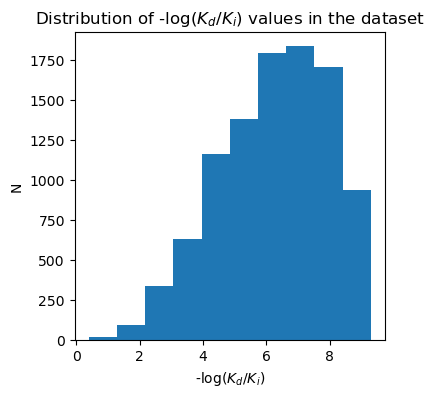

In [28]:
plt.figure(figsize=(4, 4), dpi=100)
plt.hist(data_set.df["-logKd/Ki"])
plt.title('Distribution of -log($K_d/K_i$) values in the dataset')
plt.xlabel("-log($K_d/K_i$)")
plt.ylabel("N")
plt.show()


<span style="font-family: cursive; font-size: 28px;">Neural Network Model</span>  
<span style="font-family: cursive; font-size: 16px;">We define a fully connected neural network (FCNN) using PyTorch. The FCNN has three fully connected layers with ReLU activation functions and two dropout layers, p1 and p2 are dropout probabilities for the first and second dropout layers, respectively.  Dropout was selected as regularization technique  to prevent overfitting. 
</span>    
<span style="font-family: cursive; font-size: 16px;">The input size, two hidden layer sizes, output size,  parameter are specified as input parameters to the class.
The forward function defines the feedforward pass of the network by applying the linear transformations and activations of each layer. The network takes input 'x' and returns the output on the final layer.</span>  

In [29]:
class FCNN(nn.Module): 
    
    def __init__(self,input_size, hidden_size1, hidden_size2, output_size, p1=0.7, p2=0.5): 
        super(FCNN, self).__init__()

        self.fl1 = nn.Linear(input_size, hidden_size1)
        self.dropout = nn.Dropout(p=p1)
        self.fl2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout = nn.Dropout(p=p2)         
        self.fl3 = nn.Linear(hidden_size2, output_size) 

        
    def forward(self, x):

        out = self.fl1(x)
        out = F.relu(out) 
        out = self.dropout(out)
        out = self.fl2(out)
        out = self.dropout(out)
        out = self.fl3(out)

        return out

<span style="font-family: cursive; font-size: 28px;">Train routine</span>  
<span style="font-family: cursive; font-size: 16px;">The train function defines the training loop of the fully connected neural network model. It takes as input the model to train, the device to use (CPU or GPU), the training data loader, and the optimizer. It sets the model in training mode and defines the loss function to use (in this case, L1 loss). The function then iterates through each batch of the training data loader, makes predictions on the input vectors using the model, calculates the loss between the predictions and the target values, and updates the model weights using backpropagation. It also collects the total training loss across all batches, and returns the average training loss at the end of the loop.</span>    


In [30]:
def train(model, device, train_dataloader, optim): 
    model.train()

    loss_func = torch.nn.L1Loss(reduction='sum') 
    loss_collect = 0

    
    for b_i, (input_vectors, targets) in enumerate(train_dataloader):

        input_vectors, targets = input_vectors.to(device), targets.to(device)

        optim.zero_grad() 
        pred_prob = model(input_vectors.float())

        loss = loss_func(pred_prob, targets.view(-1,1))
        loss.backward() 

        optim.step() 
        loss_collect += loss.item() 
    

        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.1f}'.format(
                epoch, b_i * len(input_vectors), len(train_dataloader.dataset),
                100 * b_i * len(input_vectors) / len(train_dataloader.dataset),
                loss.item()))
    loss_collect /= len(train_dataloader.dataset)

    return loss_collect

<span style="font-family: cursive; font-size: 28px;">Validation Routine</span>  
<span style="font-family: cursive; font-size: 16px;">The validate function is used to evaluate the performance of the neural network model on a validation dataset. The function takes the trained model, device on which the model should be evaluated: val_dataloader,  that contains the validation dataset, and epoch number as inputs.
In the function, the model is set to evaluation mode by calling model.eval(). Then, the function computes the average loss over the entire validation dataset using the L1 loss function, which is defined as torch.nn.L1Loss(reduction='sum'). This loss is collected in the loss_collect variable. Finally, the function prints the overall loss and returns the average loss over the validation dataset.
</span>    


In [31]:
def validate(model, device, val_dataloader, epoch): 

    model.eval()
    loss_collect = 0 
    loss_func = torch.nn.L1Loss(reduction='sum') 
    
    with torch.no_grad(): 
        for input_vectors, targets in val_dataloader:
            input_vectors, targets = input_vectors.to(device), targets.to(device) 
            pred_prob = model(input_vectors)
            loss_collect += loss_func(pred_prob, targets.view(-1,1)).item()
  
    loss_collect /= len(val_dataloader.dataset)
    
    print('\nTest dataset: Overall Loss: {:.1f},  ({:.2f}%)\n'.format(
        len(val_dataloader.dataset)*loss_collect,loss_collect))

    return loss_collect

<span style="font-family: cursive; font-size: 28px;">Prediction</span>  
<span style="font-family: cursive; font-size: 16px;">The predict function takes a trained model, a device (CPU or GPU), and a dataloader containing input vectors and their corresponding target values. It returns three tensors: input_all, target_all, and pred_prob_all. The input_all is a tensor containing all the input vectors from the dataloader. target_all is a tensor containing all the corresponding target values. pred_prob_all is a tensor containing all the predicted values for the input vectors.</span>    
<span style="font-family: cursive; font-size: 16px;">The function first sets the model to evaluation mode using model.eval(). Then, it iterates through the input vectors and their target values in the dataloader. For each input vector, it uses the trained model to make a prediction. It stores the input vector, target value, and predicted value in separate tensors. Finally, it returns these three tensors concatenated along the first dimension.</span>  

In [32]:
def predict(model, device, dataloader):

    model.eval()

    input_all = []
    target_all = []
    pred_prob_all = []

    with torch.no_grad():

        for input_vector, target in dataloader:

            input_vector, target = input_vector.to(device), target.to(device)

            pred_prob = model(input_vector)

            input_all.append(input_vector)
            target_all.append(target)
            pred_prob_all.append(pred_prob)

    return (
        torch.cat(input_all), 
        torch.cat(target_all), 
        torch.cat(pred_prob_all).view(-1)
    )


<span style="font-family: cursive; font-size: 28px;">Data Loader</span>  
<span style="font-family: cursive; font-size: 16px;">This code creates two data loaders: one for the training set and one for the validation set. It also splits the original data set into a training set and a validation set.The first line sets the batch size to 100, this hyperparameter was defined in order to get a reasonable computing time, sizes: 10, 50, 200 and 300 were also tested.</span>    

<span style="font-family: cursive; font-size: 16px;">The second line computes the sizes of the training and validation sets. The training set is set to be 50% of the original data set, and the validation set is set to be the remaining 50%. The torch.utils.data.random_split function is used to split the original data set into these two sets. The generator argument sets the random seed to 0, ensuring that the split is reproducible.</span> 

<span style="font-family: cursive; font-size: 16px;">The third line creates a data loader for the training set using the DataLoader class from PyTorch's torch.utils.data module. The dataset argument is set to the training set, batch_size is set to the batch size specified earlier, and shuffle is set to True to ensure that the data is shuffled before each epoch.</span> 
<span style="font-family: cursive; font-size: 16px;">The fourth line creates a data loader for the validation set using the same approach as for the training set.</span> 

In [33]:
bat_size = 50

size_train = int(len(data_set) * 0.9)
size_val = len(data_set) - size_train
train_set, val_set = torch.utils.data.random_split(data_set, 
                    [size_train, size_val], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(dataset = train_set,batch_size=bat_size,shuffle=True)

val_loader = DataLoader(dataset = val_set,batch_size=bat_size,shuffle=True)

<span style="font-family: cursive; font-size: 28px;">Run training loop</span>  
<span style="font-family: cursive; font-size: 16px;">The following code block trains the fully connected neural network (FCNN) model on the provided dataset. The FCNN has an input size equal to the input size of the dataset(described in the Data Set class), two hidden layers with 1000 and 500 nodes respectively, and an output size of 1. Before getting the size of the layers the model was trained with just one layer of 100 size. The model showed an improvement once the number of neurons was incremented. In order to avoid overfitting, the dropout was included in the model.

<span style="font-family: cursive; font-size: 16px;">The training loop runs for 300 epochs and uses the Adam optimizer with a learning rate of 0.0001. Previousley of getting these values the model was trained for just 30 epochs, the system showed improvement once the number of epochs increased, the learning rate of 0.0001 is a tipical value used for an Adam opmitizer.</span>    
<span style="font-family: cursive; font-size: 16px;">During each epoch, the train function is called with the FCNN model, the device to run the computations on, the training data loader, and the optimizer. The train function iterates over the training data and performs forward and backward passes through the model to update its parameters. It also collects the training loss during each iteration and returns the average training loss for the epoch.</span>  

<span style="font-family: cursive; font-size: 16px;">After each epoch, the validate function is called with the FCNN model, the device to run the computations on, the validation data loader, and the current epoch number. The validate function evaluates the FCNN on the validation data and returns the average validation loss.

<span style="font-family: cursive; font-size: 16px;">The training loop keeps track of the training and validation losses for each epoch and plots them using matplotlib. The training loss and validation loss both decrease and stabilize at a specific point, this may indicates an good fit</span>  

epoch: 1 [0/8892 (0%)]	 training loss: 345.2
epoch: 1 [500/8892 (6%)]	 training loss: 284.1
epoch: 1 [1000/8892 (11%)]	 training loss: 241.9
epoch: 1 [1500/8892 (17%)]	 training loss: 146.6
epoch: 1 [2000/8892 (22%)]	 training loss: 100.8
epoch: 1 [2500/8892 (28%)]	 training loss: 93.3
epoch: 1 [3000/8892 (34%)]	 training loss: 73.8
epoch: 1 [3500/8892 (39%)]	 training loss: 71.0
epoch: 1 [4000/8892 (45%)]	 training loss: 57.5
epoch: 1 [4500/8892 (51%)]	 training loss: 71.1
epoch: 1 [5000/8892 (56%)]	 training loss: 65.7
epoch: 1 [5500/8892 (62%)]	 training loss: 64.9
epoch: 1 [6000/8892 (67%)]	 training loss: 58.5
epoch: 1 [6500/8892 (73%)]	 training loss: 62.3
epoch: 1 [7000/8892 (79%)]	 training loss: 54.7
epoch: 1 [7500/8892 (84%)]	 training loss: 69.0
epoch: 1 [8000/8892 (90%)]	 training loss: 67.3
epoch: 1 [8500/8892 (96%)]	 training loss: 66.8

Test dataset: Overall Loss: 1239.3,  (1.25%)

epoch: 2 [0/8892 (0%)]	 training loss: 63.4
epoch: 2 [500/8892 (6%)]	 training loss: 52.2


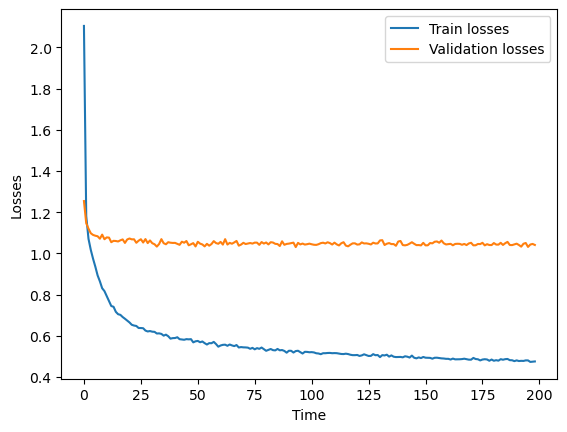

In [34]:
learning_rate = 0.0001 
torch.manual_seed(0)
device = torch.device("cpu")

model = FCNN(input_size = data_set.input_size, hidden_size1=1000,hidden_size2=500, output_size=1) 
optimizer = optim.Adam(model.parameters(), lr = learning_rate) 

losses_train = []
losses_val = []

for epoch in range(1, 200): 
    train_loss = train(model, device, train_loader, optimizer)
    losses_train.append(train_loss)

    val_loss = validate(model, device, val_loader, epoch)
    losses_val.append(val_loss)

plt.plot(losses_train, label ='Train losses')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Train losses')

plt.plot(losses_val, label ='Validation losses')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Losses')

plt.show()

<span style="font-family: cursive; font-size: 36px;">•Model Statistics</span>  


<span style="font-family: cursive; font-size: 28px;">Training</span>    
<span style="font-family: cursive; font-size: 16px;">This code evaluates the performance of the trained model on the training dataset. First, the predict function is called to obtain the predicted probabilities (pred_prob_all) and the actual target values (target_all) for all input vectors in the train_loader. Then, several evaluation metrics are calculated using the sklearn library, including the R-squared score (r2), mean absolute error (mae), root mean squared error (rmse), and Pearson correlation coefficient (r) (Scipy libriy used).</span>  

<span style="font-family: cursive; font-size: 16px;">Finally, a scatter plot is created with the actual target values on the x-axis and the predicted values on the y-axis. The plot also includes a diagonal line representing perfect predictions and a legend with the calculated evaluation metrics. The plot shows how well the model predictions match the actual target values, with the closer the points are to the diagonal line indicating better predictions.</span>  

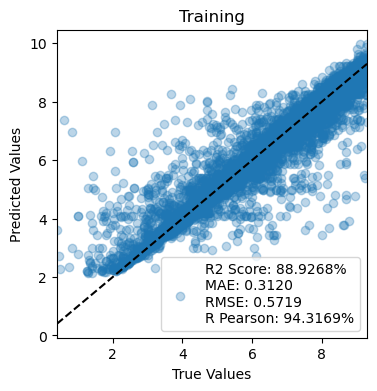

In [35]:
input_all, target_all, pred_prob_all = predict(model, device, train_loader)

r2 = r2_score(target_all, pred_prob_all)
mae = mean_absolute_error(target_all, pred_prob_all)
rmse = mean_squared_error(target_all, pred_prob_all, squared=False)
r, _ = pearsonr(target_all, pred_prob_all)

legend_text = "R2 Score: {:.4f}%\nMAE: {:.4f}\nRMSE: {:.4f}\nR Pearson: {:.4f}%".format(r2*100, mae, rmse, r*100)

plt.figure(figsize=(4, 4), dpi=100)
plt.scatter(target_all, pred_prob_all, alpha=0.3)
plt.plot([min(target_all), max(target_all)], [min(target_all),
        max(target_all)], color="k", ls="--")
plt.xlim([min(target_all), max(target_all)])
plt.title('Training')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend([legend_text], loc="lower right")
plt.show()

<span style="font-family: cursive; font-size: 28px;">Validation</span>  
<span style="font-family: cursive; font-size: 16px;">This code predicts the target values for the validation set using the trained model and evaluates the model's performance same as the training data set</span>    
<span style="font-family: cursive; font-size: 16px;"></span>  

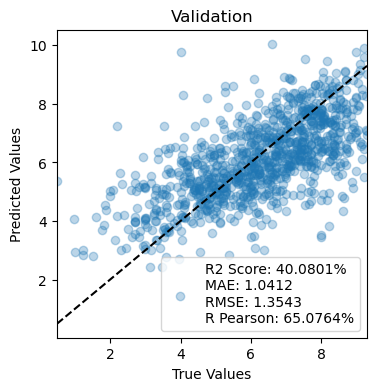

In [36]:
input_all, target_all, pred_prob_all = predict(model, device, val_loader)

r2 = r2_score(target_all, pred_prob_all)
mae = mean_absolute_error(target_all, pred_prob_all)
rmse = mean_squared_error(target_all, pred_prob_all, squared=False)
r, _ = pearsonr(target_all, pred_prob_all)

legend_text = "R2 Score: {:.4f}%\nMAE: {:.4f}\nRMSE: {:.4f}\nR Pearson: {:.4f}%".format(r2*100, mae, rmse, r*100)

plt.figure(figsize=(4, 4), dpi=100)
plt.scatter(target_all, pred_prob_all, alpha=0.3)
plt.plot([min(target_all), max(target_all)], [min(target_all),
        max(target_all)], color="k", ls="--")
plt.xlim([min(target_all), max(target_all)])
plt.title('Validation')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend([legend_text], loc="lower right")
plt.show()

<span style="font-family: cursive; font-size: 28px;">Computing Time</span>  
<span style="font-family: cursive; font-size: 16px;">The code was run in a destkop computer of Bilodeau Group:</span> 

<span style="font-family: cursive; font-size: 16px;">OS : Rocky Linux 8.7</span>  
<span style="font-family: cursive; font-size: 16px;">Memory : 251.5 GiB</span>  
<span style="font-family: cursive; font-size: 16px;">Proccessor : AMD® Ryzen threadripper pro 5965wx 24-cores × 48</span>  
<span style="font-family: cursive; font-size: 16px;">CUDA : NVIDIA GeForce RTX 3090/PCIe/SSE2</span>  

<span style="font-family: cursive; font-size: 16px;">Computing time is printed above:</span>  

In [37]:
finish_time = time.time()
time = finish_time -start_time
print("\n //// Process finished: {:3f} seconds ////".format(time))


 //// Process finished: 161.968930 seconds ////


<span style="font-family: cursive; font-size: 36px;">•Conclusion</span>  

<span style="font-family: cursive; font-size: 16px;">Based on the results presented, can be concluded that the Daniel NN model outperformed all other models on the test set, achieving the lowest RMSE of 0.5719. This suggests that the Daniel NN model is a good approach for the prediction task. However, it is important to note that the performance of the model on the validation set was not as good as some training routine, which could indicate overfitting.</span> 

![Texto alternativo](benchmarks.png)



<span style="font-family: cursive; font-size: 16px;">Further investigation and experimentation may be needed to confirm the effectiveness and generalizability of the Daniel NN model. Overall, the results indicate that deep learning approaches can provide accurate predictions for the task at hand, and further optimization and refinement of these models could lead to even better performance.</span> 

<span style="font-family: cursive; font-size: 28px;">Reference</span> 

<span style="font-family: cursive; font-size: 16px;">Jha, A.R. (2020). Mastering PyTorch. Packt Publishing.</span> 